In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
edits = pd.read_csv('../../data/edits_sampled_5000_users.csv')
edits.head(2)

,user_id,article_id,revision_id,namespace,timestamp,md5,reverted,reverted_user_id,reverted_revision_id,delta,cur_size
0,648835,6829695,362024306,0,2010-05-14 03:36:11,c78ce24cd635b1afddb90057adeb7ecd,0,-1,-1,81,792
1,648835,6829695,362024744,0,2010-05-14 03:40:09,45e5bd27761b78854c57e039eba10a63,0,-1,-1,-1,791


# Initial analysis

In [3]:
edits['time'] = pd.to_datetime(edits.timestamp)

In [4]:
df = edits[['user_id', 'article_id', 'revision_id', 'time', 'reverted']]

In [36]:
users = df.user_id.unique()

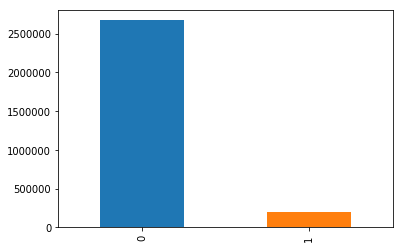

In [5]:
df.reverted.value_counts().plot.bar()

In [6]:
edits_year = df.time.apply(lambda x: x.year)
edits_month = df.time.apply(lambda x: x.month)
edits_day = df.time.apply(lambda x: x.day)

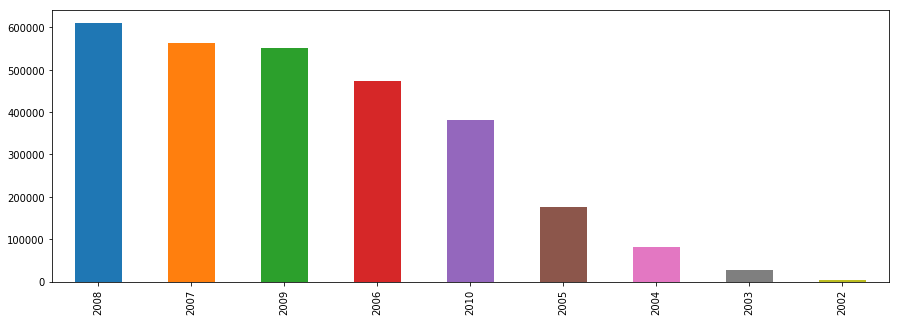

In [7]:
plt.figure(figsize=(15,5))
edits_year.value_counts().plot.bar()

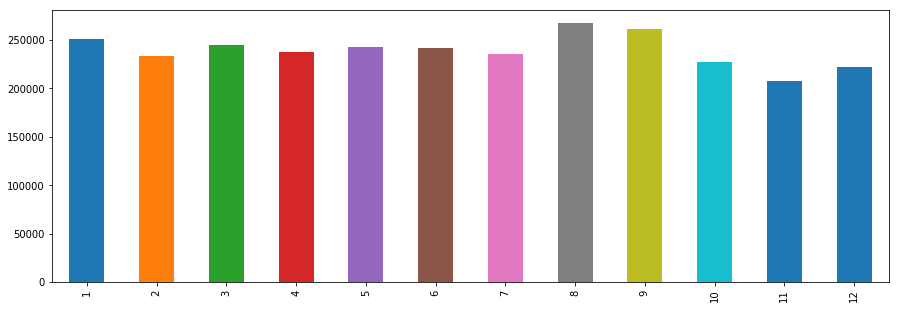

In [8]:
plt.figure(figsize=(15,5))
edits_month.value_counts().sort_index().plot.bar()

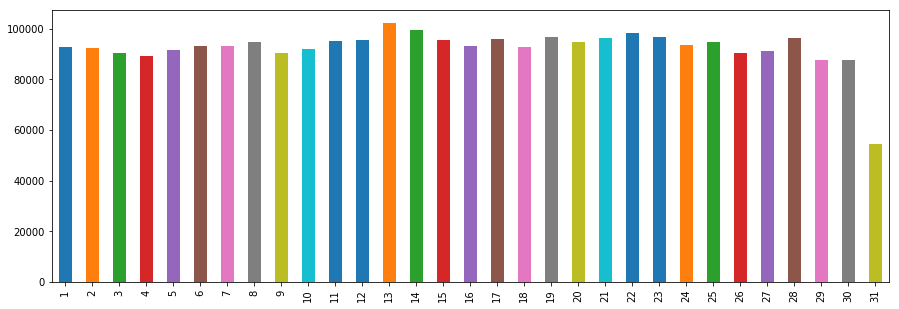

In [10]:
plt.figure(figsize=(15,5))
edits_day.value_counts().sort_index().plot.bar()

# Getting info from reverted updates

In [11]:
reverted = df[df.reverted==1]
reverted.head()

,user_id,article_id,revision_id,time,reverted
389,474667,15120912,370543807,2010-06-28 05:50:15,1
399,474667,4167276,380641886,2010-08-24 04:33:34,1
400,474667,4167276,380642316,2010-08-24 04:36:59,1
401,474667,4167276,380643709,2010-08-24 04:47:53,1
402,474667,4167276,380644342,2010-08-24 04:52:54,1


In [12]:
first_revert = df[df.reverted==1].groupby(['user_id'])['time'].min()
first_revert = pd.DataFrame(first_revert)
first_revert.head(2)

,time
user_id,
60,2009-11-10 19:21:18
911,2009-12-06 18:06:43


In [13]:
first_update = df.groupby(['user_id'])['time'].min()
first_update = pd.DataFrame(first_update)
first_update.head(2)

,time
user_id,
44,2008-07-26 22:57:50
54,2010-07-05 20:37:37


In [14]:
revert_count = df[df.reverted==1].groupby(['user_id'])['time'].count()
revert_count = pd.DataFrame(revert_count)
revert_count = revert_count.rename(columns={'time': 'reverted_count'})
revert_count.head()

,reverted_count
user_id,
60,2
911,1
1673,4
1808,98
3053,9


In [15]:
total_updates = df.groupby(['user_id'])['time'].count()
total_updates = pd.DataFrame(total_updates)
total_updates = total_updates.rename(columns={'time': 'total_updates'})
total_updates.head()

,total_updates
user_id,
44,33
54,1
60,14
251,2
546,3


In [16]:
df1 = pd.merge(df, first_revert, how='left', on='user_id', suffixes=('_update', '_first_revert'))
df1.head(2)

,user_id,article_id,revision_id,time_update,reverted,time_first_revert
0,648835,6829695,362024306,2010-05-14 03:36:11,0,NaT
1,648835,6829695,362024744,2010-05-14 03:40:09,0,NaT


In [17]:
df2 = pd.merge(df1, first_update, how='left', on='user_id')
df2 = df2.rename(columns={'time': 'time_first_update'})
df2.head(2)

,user_id,article_id,revision_id,time_update,reverted,time_first_revert,time_first_update
0,648835,6829695,362024306,2010-05-14 03:36:11,0,NaT,2010-05-14 03:36:11
1,648835,6829695,362024744,2010-05-14 03:40:09,0,NaT,2010-05-14 03:36:11


In [18]:
df3 = pd.merge(df2, revert_count, how='left', on='user_id')
df3.head(2)

,user_id,article_id,revision_id,time_update,reverted,time_first_revert,time_first_update,reverted_count
0,648835,6829695,362024306,2010-05-14 03:36:11,0,NaT,2010-05-14 03:36:11,NaN
1,648835,6829695,362024744,2010-05-14 03:40:09,0,NaT,2010-05-14 03:36:11,NaN


In [19]:
df4 = pd.merge(df3, total_updates, how='left', on='user_id')
df4.head(2)

,user_id,article_id,revision_id,time_update,reverted,time_first_revert,time_first_update,reverted_count,total_updates
0,648835,6829695,362024306,2010-05-14 03:36:11,0,NaT,2010-05-14 03:36:11,NaN,8
1,648835,6829695,362024744,2010-05-14 03:40:09,0,NaT,2010-05-14 03:36:11,NaN,8


# Correlation between days before first revert and number the updated after first revert?

In [20]:
# We only want users that had at least one update reverted
reverted_df = df4[df4.reverted_count >= 1]
reverted_df.shape

(2832548, 9)

In [21]:
time_before_revert = reverted_df.time_first_revert - reverted_df.time_first_update
reverted_df['days_before_revert'] = time_before_revert.apply(lambda x: x.days)
reverted_df.head()

/Users/leportella/miniconda3/envs/wiki/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,article_id,revision_id,time_update,reverted,time_first_revert,time_first_update,reverted_count,total_updates,days_before_revert
370,474667,1648162,267412504,2009-01-30 15:12:48,0,2010-06-28 05:50:15,2007-01-09 15:07:36,5.0,56,1265
371,474667,1648162,267412947,2009-01-30 15:15:46,0,2010-06-28 05:50:15,2007-01-09 15:07:36,5.0,56,1265
372,474667,261059,315975729,2009-09-24 19:21:35,0,2010-06-28 05:50:15,2007-01-09 15:07:36,5.0,56,1265
373,474667,261059,321293112,2009-10-21 23:56:37,0,2010-06-28 05:50:15,2007-01-09 15:07:36,5.0,56,1265
374,474667,4848272,296665379,2009-06-16 01:25:57,0,2010-06-28 05:50:15,2007-01-09 15:07:36,5.0,56,1265


In [22]:
# And we want to check the updated that happened after the first revert
after_revert = reverted_df[reverted_df.time_update >= reverted_df.time_first_revert]
updates_after_revert = after_revert.groupby('user_id')['time_update'].count()

updates_after_revert = pd.DataFrame(updates_after_revert)
updates_after_revert = updates_after_revert.rename(columns={'time_update': 'updates_after_revert'})
updates_after_revert.head()

,updates_after_revert
user_id,
60,11
911,48
1673,93
1808,319
3053,248


In [23]:
df = pd.merge(reverted_df, updates_after_revert, how='left', on='user_id')

Text(0.5, 1.0, 'Days before revert vs number of updates after revert')

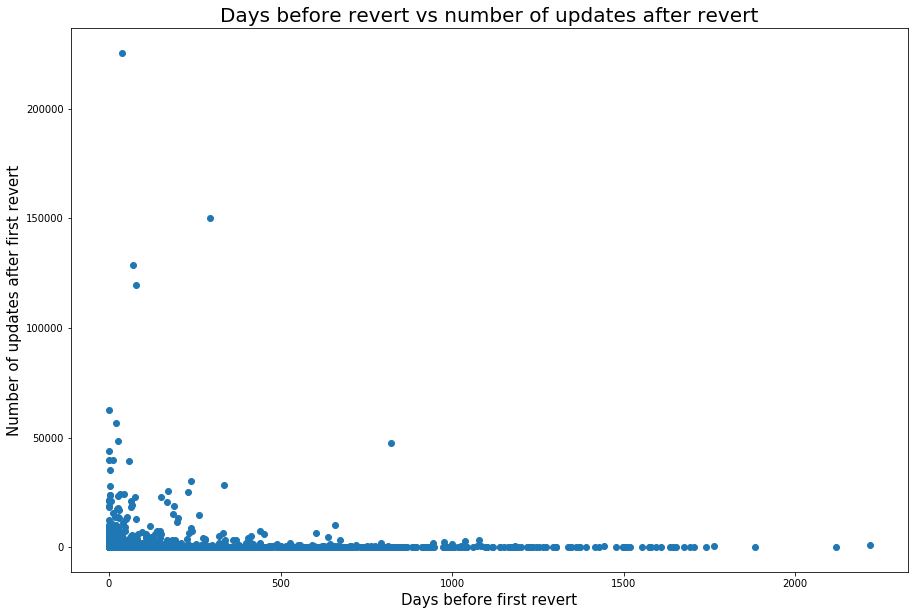

In [25]:
users_behavior = df.groupby('user_id').first()

plt.figure(figsize=(15,10))
plt.scatter(users_behavior.days_before_revert, users_behavior.updates_after_revert)
plt.xlabel('Days before first revert', fontsize=15)
plt.ylabel('Number of updates after first revert', fontsize=15)
plt.title('Days before revert vs number of updates after revert', fontsize=20)

# Analysis through time

In [26]:
from datetime import date 

df4['date'] = df4.time_update.apply(lambda x: x.date())
df4['date_monthly'] = df4.time_update.apply(lambda x: date(x.date().year, x.date().month, 1))

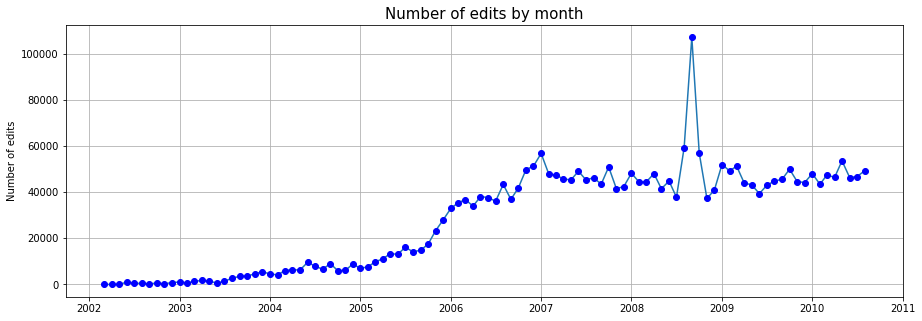

In [27]:
plt.figure(figsize=(15,5))
plt.plot(df4.date_monthly.value_counts().sort_index())
plt.plot(df4.date_monthly.value_counts().sort_index(), 'bo')
plt.ylabel('Number of edits')
plt.title('Number of edits by month', fontsize=15)
plt.grid()

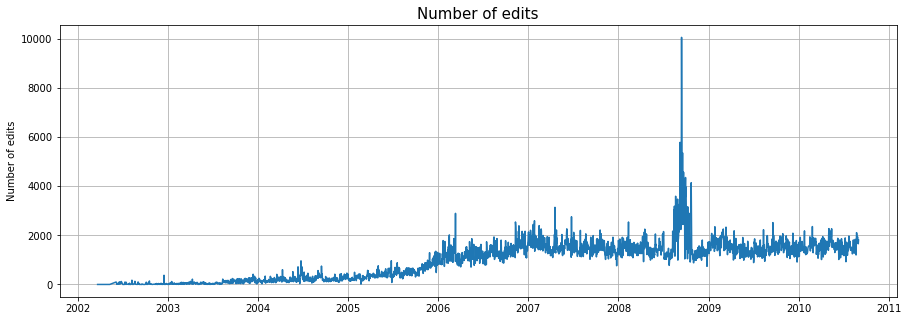

In [28]:
plt.figure(figsize=(15,5))
plt.plot(df4.date.value_counts().sort_index())
plt.ylabel('Number of edits')
plt.title('Number of edits', fontsize=15)
plt.grid()

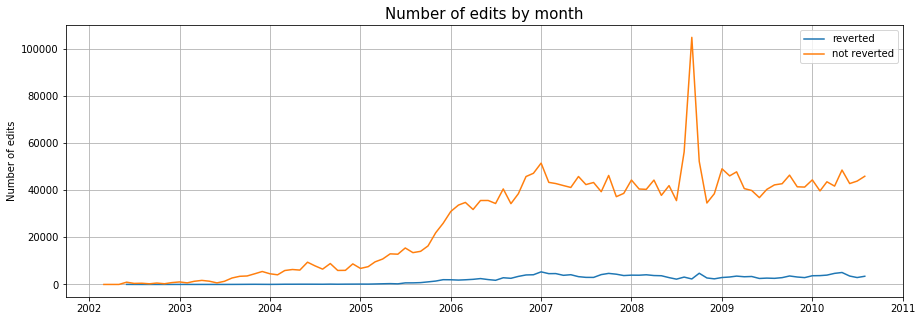

In [29]:
reverted = df4[df4.reverted==1]
not_reverted = df4[df4.reverted==0]

plt.figure(figsize=(15,5))
plt.plot(reverted.date_monthly.value_counts().sort_index())
plt.plot(not_reverted.date_monthly.value_counts().sort_index())
plt.legend(['reverted', 'not reverted'])
plt.ylabel('Number of edits')
plt.title('Number of edits by month', fontsize=15)
plt.grid()

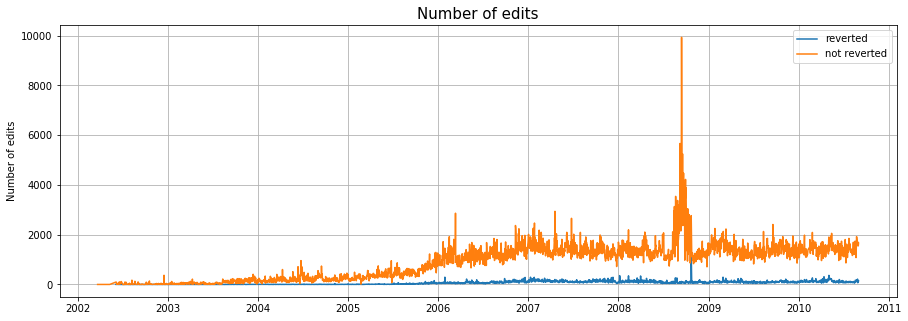

In [30]:
reverted = df4[df4.reverted==1]
not_reverted = df4[df4.reverted==0]

plt.figure(figsize=(15,5))
plt.plot(reverted.date.value_counts().sort_index())
plt.plot(not_reverted.date.value_counts().sort_index())
plt.legend(['reverted', 'not reverted'])
plt.ylabel('Number of edits')
plt.title('Number of edits', fontsize=15)
plt.grid()

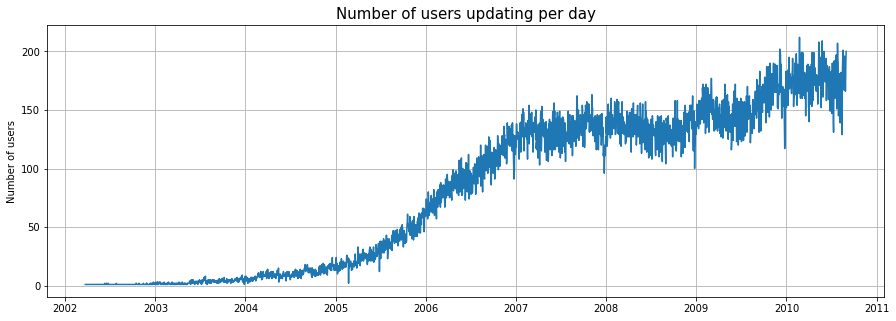

In [31]:
user_by_date = pd.crosstab(df4.date, df4.user_id)
user_by_date[user_by_date>1] = 1

user_by_date = user_by_date.sum(axis=1)

plt.figure(figsize=(15,5))
plt.plot(user_by_date)
plt.ylabel('Number of users')
plt.title('Number of users updating per day', fontsize=15)
plt.grid()

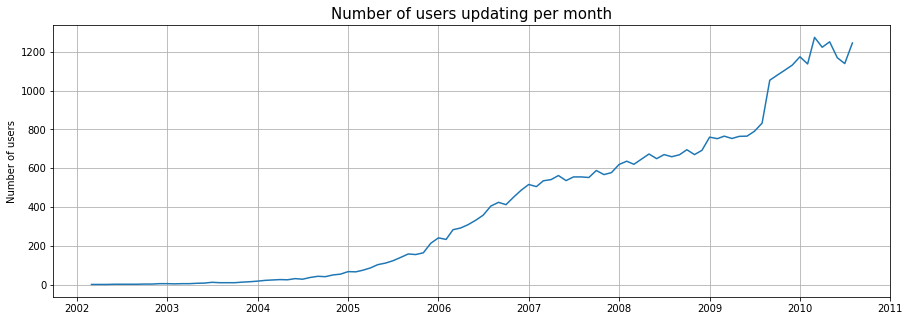

In [32]:
user_by_date = pd.crosstab(df4.date_monthly, df4.user_id)
user_by_date[user_by_date>1] = 1

user_by_date = user_by_date.sum(axis=1)

plt.figure(figsize=(15,5))
plt.plot(user_by_date)
plt.ylabel('Number of users')
plt.title('Number of users updating per month', fontsize=15)
plt.grid()

# Data by users

In [35]:
pd.merge(df4, updates_after_revert, how='left', on='user_id')

,user_id,article_id,revision_id,time_update,reverted,time_first_revert,time_first_update,reverted_count,total_updates,date,date_monthly,updates_after_revert
0,648835,6829695,362024306,2010-05-14 03:36:11,0,NaT,2010-05-14 03:36:11,NaN,8,2010-05-14,2010-05-01,NaN
1,648835,6829695,362024744,2010-05-14 03:40:09,0,NaT,2010-05-14 03:36:11,NaN,8,2010-05-14,2010-05-01,NaN
2,648835,6829695,362024864,2010-05-14 03:41:08,0,NaT,2010-05-14 03:36:11,NaN,8,2010-05-14,2010-05-01,NaN
3,648835,6829695,362025520,2010-05-14 03:46:18,0,NaT,2010-05-14 03:36:11,NaN,8,2010-05-14,2010-05-01,NaN
4,648835,6829695,363391420,2010-05-21 14:17:53,0,NaT,2010-05-14 03:36:11,NaN,8,2010-05-21,2010-05-01,NaN
5,648835,6829695,365388021,2010-06-01 08:14:35,0,NaT,2010-05-14 03:36:11,NaN,8,2010-06-01,2010-06-01,NaN
6,648835,6829695,366535469,2010-06-07 10:40:03,0,NaT,2010-05-14 03:36:11,NaN,8,2010-06-07,2010-06-01,NaN
7,648835,1444125,373246191,2010-07-13 12:10:48,0,NaT,2010-05-14 03:36:11,NaN,8,2010-07-13,2010-07-01,NaN
8,785663,5605670,337234875,2010-01-11 19:30:07,0,NaT,2010-01-11 19:30:07,NaN,1,2010-01-11,2010-01-01,NaN
9,529589,413522,361622526,2010-05-12 04:57:21,0,NaT,2010-05-12 04:57:21,NaN,1,2010-05-12,2010-05-01,NaN
